In [44]:
import pandas as pd
import numpy as np
import skfuzzy as fuzz
from skfuzzy import control as ctrl
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn import preprocessing

In [45]:
df = pd.read_csv('dados_autent_bancaria.csv')
df.columns =['x1','x2','x3','x4','cls']
df.head(5)

,x1,x2,x3,x4,cls
0,4.54590,8.1674,-2.45860,-1.46210,0
1,3.86600,-2.6383,1.92420,0.10645,0
2,3.45660,9.5228,-4.01120,-3.59440,0
3,0.32924,-4.4552,4.57180,-0.98880,0
4,4.36840,9.6718,-3.96060,-3.16250,0
5,3.59120,3.0129,0.72888,0.56421,0
6,2.09220,-6.8100,8.46360,-0.60216,0
7,3.20320,5.7588,-0.75345,-0.61251,0
8,1.53560,9.1772,-2.27180,-0.73535,0
9,1.22470,8.7779,-2.21350,-0.80647,0


In [46]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1371 entries, 0 to 1370
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   x1      1371 non-null   float64
 1   x2      1371 non-null   float64
 2   x3      1371 non-null   float64
 3   x4      1371 non-null   float64
 4   cls     1371 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 53.7 KB


Avaliando os valores dos dados vemos que temos valores maximos e minimos para cada universo. Entao vou utilizar os valores maximos e minimos para configuracao das regras. 

variance ->  Max 6.824800    Min -7.042100
    

&nbsp;
skewness ->  Max 12.951600   Min -13.773100
    

&nbsp;
curtosis ->  Max 17.927400	 Min -5.286100	
    

&nbsp;
entropy  ->  Max 2.449500	 Min -8.548200

In [47]:
df.describe()

,x1,x2,x3,x4,cls
count,1371.000000,1371.000000,1371.000000,1371.000000,1371.000000
mean,0.431410,1.917434,1.400694,-1.192200,0.444931
std,2.842494,5.868359,4.310105,2.101683,0.497139
min,-7.042100,-13.773100,-5.286100,-8.548200,0.000000
25%,-1.774700,-1.711300,-1.553350,-2.417000,0.000000
50%,0.495710,2.313400,0.616630,-0.586650,0.000000
75%,2.814650,6.813100,3.181600,0.394810,1.000000
max,6.824800,12.951600,17.927400,2.449500,1.000000


<AxesSubplot:>

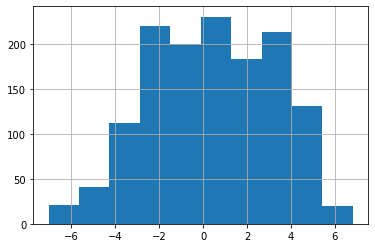

In [48]:
df['x1'].hist(bins=10)

<AxesSubplot:>

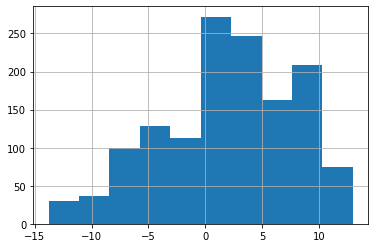

In [49]:
df['x2'].hist(bins=10)

<AxesSubplot:>

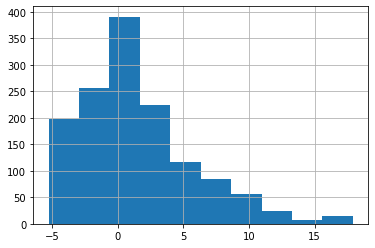

In [50]:
df['x3'].hist(bins=10)

<AxesSubplot:>

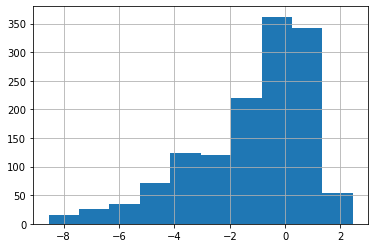

In [51]:
df['x4'].hist(bins=10)

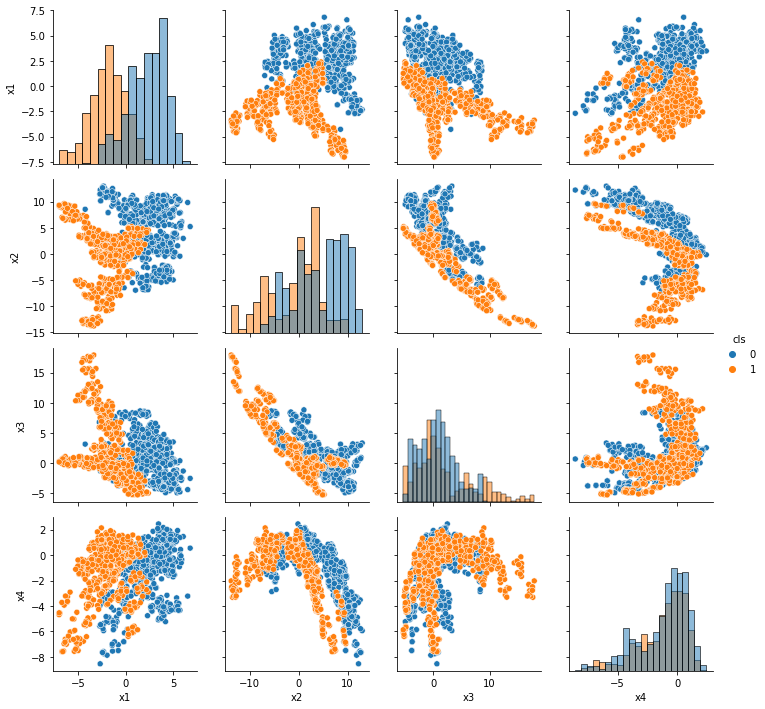

In [52]:
g = sns.PairGrid(df, hue="cls")
g.map_diag(sns.histplot)
g.map_offdiag(sns.scatterplot)
g.add_legend()

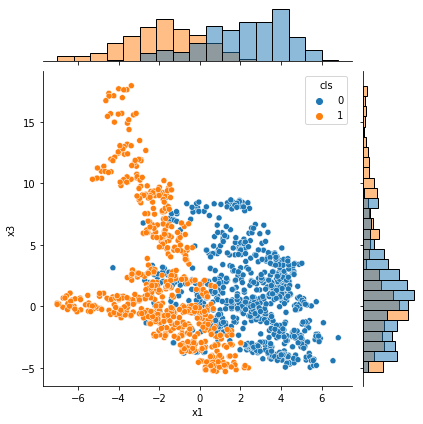

In [53]:
import warnings
warnings.filterwarnings('ignore')

g = sns.JointGrid(data=df, x="x1", y="x3", hue="cls")
g.plot(sns.scatterplot, sns.histplot)

Fazendo as combinações das variáveis

In [54]:
df.corr()

,x1,x2,x3,x4,cls
x1,1.000000,0.263333,-0.380358,0.276666,-0.724655
x2,0.263333,1.000000,-0.786729,-0.526896,-0.444281
x3,-0.380358,-0.786729,1.000000,0.319219,0.155346
x4,0.276666,-0.526896,0.319219,1.000000,-0.023200
cls,-0.724655,-0.444281,0.155346,-0.023200,1.000000


In [55]:
df_corr = df.corr()
df_corr = df_corr.style.background_gradient(cmap='RdBu')
df_corr

,x1,x2,x3,x4,cls
x1,1.000000,0.263333,-0.380358,0.276666,-0.724655
x2,0.263333,1.000000,-0.786729,-0.526896,-0.444281
x3,-0.380358,-0.786729,1.000000,0.319219,0.155346
x4,0.276666,-0.526896,0.319219,1.000000,-0.023200
cls,-0.724655,-0.444281,0.155346,-0.023200,1.000000


In [56]:
df['cls'] = df['cls'].apply(lambda x: 'c'+str(x + 1))

df.head()

,x1,x2,x3,x4,cls
0,4.54590,8.1674,-2.4586,-1.46210,c1
1,3.86600,-2.6383,1.9242,0.10645,c1
2,3.45660,9.5228,-4.0112,-3.59440,c1
3,0.32924,-4.4552,4.5718,-0.98880,c1
4,4.36840,9.6718,-3.9606,-3.16250,c1


In [57]:
def normalize(df):
    result = df.copy()
    for feature_name in df.columns:
        if df[feature_name].dtypes != "object":
            max_value = df[feature_name].max()
            min_value = df[feature_name].min()
            result[feature_name] = ((df[feature_name] - min_value) / (max_value - min_value))*100
    return result


df_normalized = normalize(df)

df_normalized.describe()

,x1,x2,x3,x4
count,1371.000000,1371.000000,1371.000000,1371.000000
mean,53.894598,58.711732,28.805627,66.886716
std,20.498413,21.958557,18.567234,19.110209
min,0.000000,0.000000,0.000000,0.000000
25%,37.985419,45.133528,16.080083,55.749839
50%,54.358292,60.193379,25.428005,72.392864
75%,71.081136,77.030612,36.477481,81.317094
max,100.000000,100.000000,100.000000,100.000000


In [58]:
train, test = train_test_split(df_normalized, test_size=0.2)

train.to_csv("./train_normalized.csv",index=False)
test.to_csv("./test_normalized.csv",index=False)

Aplicando as regras no scfuzzy. Primeiro crio as variaveis que vao definir os universos. 

In [59]:
# Leio os dados para o treino 
dfTraining = pd.read_csv('train_normalized.csv')
dfTraining.columns =['x1','x2','x3','x4','cls']
dfTraining.describe()

,x1,x2,x3,x4
count,1096.000000,1096.000000,1096.000000,1096.000000
mean,53.760899,58.969558,28.770667,66.461033
std,20.476935,21.951134,18.777488,19.208001
min,0.000000,0.000000,0.000000,0.000000
25%,37.997678,46.418856,16.113468,54.738263
50%,53.792268,60.755032,25.178883,71.904944
75%,70.522251,77.061576,36.148900,81.161334
max,100.000000,100.000000,100.000000,97.390363


In [60]:
# Gerando o universo para variancia
variance =  np.arange(0, 100, 1)
# Gerando o universo para skewness
skewness =  np.arange(0, 100, 1)
# Gerando o universo para curtosis
curtosis =  np.arange(0, 100, 1)
# Gerando o universo para entropy
entropy =  np.arange(0, 100, 1)
# Gerando o universo para a saida
clsuniverse =  np.arange(0, 2, 1)

In [61]:
# Baseado nos dados para treinamento seto os trangulos no scfuzzy

variance_vlow = fuzz.trimf(variance, [0, 0, 38])
variance_low = fuzz.trimf(variance, [0, 38, 54])
variance_med = fuzz.trimf(variance, [38, 54, 71])
variance_hig = fuzz.trimf(variance, [54, 71, 100])
variance_vhig = fuzz.trimf(variance, [71, 100, 100])

skewness_vlow = fuzz.trimf(skewness, [0, 0, 30])
skewness_low = fuzz.trimf(skewness, [0, 30, 60])
skewness_med = fuzz.trimf(skewness, [30, 60, 77])
skewness_hig = fuzz.trimf(skewness, [60, 77, 100])
skewness_vhig = fuzz.trimf(skewness, [77, 100, 100])

curtosis_low = fuzz.trimf(curtosis, [0, 0, 15])
curtosis_med = fuzz.trimf(curtosis, [0, 15, 36])
curtosis_hig = fuzz.trimf(curtosis, [25, 60, 100])
curtosis_vhig = fuzz.trimf(curtosis, [60, 100, 100])

entropy_low = fuzz.trimf(entropy, [0, 0, 56])
entropy_med = fuzz.trimf(entropy, [0, 56, 72])
entropy_hig = fuzz.trimf(entropy, [56, 72, 100])

output_true = fuzz.trimf(clsuniverse, [1,1,1])
output_false = fuzz.trimf(clsuniverse, [0,0,0])

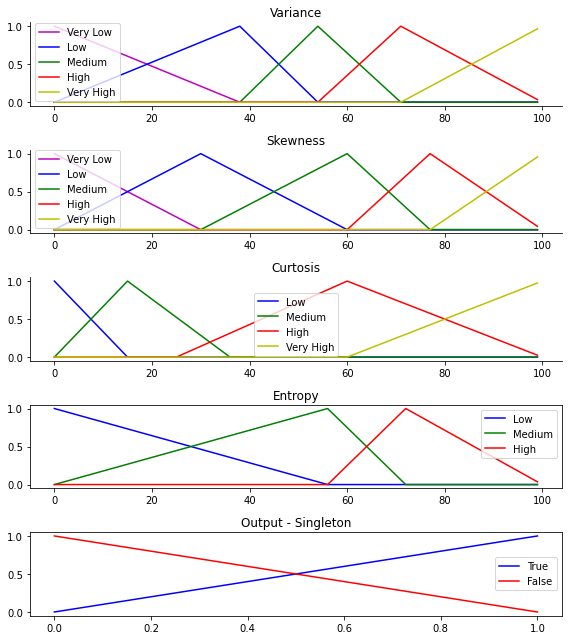

In [62]:
# Visualize these universes and membership functions
fig, (ax0, ax1, ax2, ax3, ax4) = plt.subplots(nrows=5, figsize=(8, 9))

ax0.plot(variance, variance_vlow, 'm', label='Very Low')
ax0.plot(variance, variance_low, 'b', label='Low')
ax0.plot(variance, variance_med, 'g', label='Medium')
ax0.plot(variance, variance_hig, 'r', label='High')
ax0.plot(variance, variance_vhig, 'y', label='Very High')
ax0.set_title('Variance')
ax0.legend()

ax1.plot(skewness, skewness_vlow, 'm', linewidth=1.5, label='Very Low')
ax1.plot(skewness, skewness_low, 'b', linewidth=1.5, label='Low')
ax1.plot(skewness, skewness_med, 'g', linewidth=1.5, label='Medium')
ax1.plot(skewness, skewness_hig, 'r', linewidth=1.5, label='High')
ax1.plot(skewness, skewness_vhig, 'y', linewidth=1.5, label='Very High')
ax1.set_title('Skewness')
ax1.legend()

ax2.plot(curtosis, curtosis_low, 'b', linewidth=1.5, label='Low')
ax2.plot(curtosis, curtosis_med, 'g', linewidth=1.5, label='Medium')
ax2.plot(curtosis, curtosis_hig, 'r', linewidth=1.5, label='High')
ax2.plot(curtosis, curtosis_vhig, 'y', linewidth=1.5, label='Very High')
ax2.set_title('Curtosis')
ax2.legend()

ax3.plot(entropy, entropy_low, 'b', linewidth=1.5, label='Low')
ax3.plot(entropy, entropy_med, 'g', linewidth=1.5, label='Medium')
ax3.plot(entropy, entropy_hig, 'r', linewidth=1.5, label='High')
ax3.set_title('Entropy')
ax3.legend()

ax4.plot(clsuniverse, output_true, 'b', linewidth=1.5, label='True')
ax4.plot(clsuniverse, output_false, 'r', linewidth=1.5, label='False')
ax4.set_title('Output - Singleton')
ax4.legend()

# Turn off top/right axes
for ax in (ax0, ax1, ax2):
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.get_xaxis().tick_bottom()
    ax.get_yaxis().tick_left()

plt.tight_layout()

Gerei as regras em um outro programa utilizando wang mendel. Deu um total de 30 regras nas quais vou aplicar todas diretamente no matlab.

Update: Apos as regras serem aplicadas a acuracia nao ficou boa (em torno de 35%) entao decidi reparticionar os universos de novo em conjuntos menores

In [66]:
# Baseado nos dados para treinamento seto os trangulos no scfuzzy

variance_low = fuzz.trimf(variance, [0, 0, 54])
variance_med = fuzz.trimf(variance, [0, 54, 100])
variance_hig = fuzz.trimf(variance, [54, 100, 100])

skewness_low = fuzz.trimf(skewness, [0, 0, 60])
skewness_med = fuzz.trimf(skewness, [0, 60, 100])
skewness_hig = fuzz.trimf(skewness, [60, 100, 100])

curtosis_low = fuzz.trimf(curtosis, [0, 0, 36])
curtosis_med = fuzz.trimf(curtosis, [0, 36, 100])
curtosis_hig = fuzz.trimf(curtosis, [36, 100, 100])

entropy_low = fuzz.trimf(entropy, [0, 0, 56])
entropy_med = fuzz.trimf(entropy, [0, 56, 100])
entropy_hig = fuzz.trimf(entropy, [56, 100, 100])

output_true = fuzz.trimf(clsuniverse, [1,1,1])
output_false = fuzz.trimf(clsuniverse, [0,0,0])

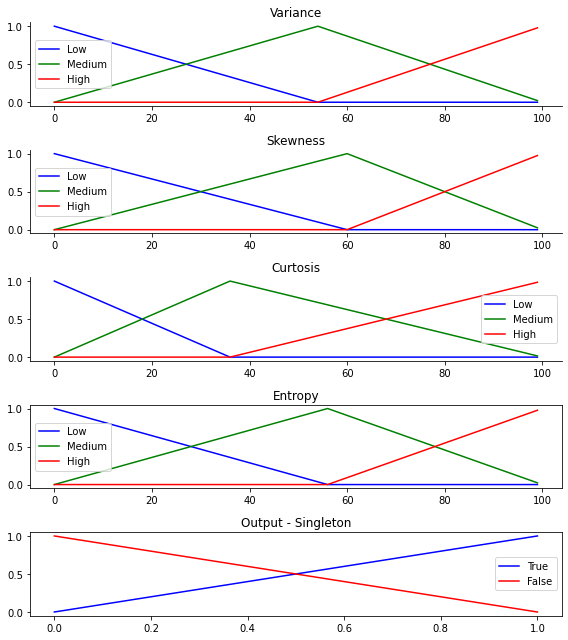

In [67]:
# Visualize these universes and membership functions
ax0 = []
ax1 = []
ax2 = []
ax3 = []

fig, (ax0, ax1, ax2, ax3, ax4) = plt.subplots(nrows=5, figsize=(8, 9))

ax0.plot(variance, variance_low, 'b', label='Low')
ax0.plot(variance, variance_med, 'g', label='Medium')
ax0.plot(variance, variance_hig, 'r', label='High')
ax0.set_title('Variance')
ax0.legend()

ax1.plot(skewness, skewness_low, 'b', linewidth=1.5, label='Low')
ax1.plot(skewness, skewness_med, 'g', linewidth=1.5, label='Medium')
ax1.plot(skewness, skewness_hig, 'r', linewidth=1.5, label='High')
ax1.set_title('Skewness')
ax1.legend()

ax2.plot(curtosis, curtosis_low, 'b', linewidth=1.5, label='Low')
ax2.plot(curtosis, curtosis_med, 'g', linewidth=1.5, label='Medium')
ax2.plot(curtosis, curtosis_hig, 'r', linewidth=1.5, label='High')
ax2.set_title('Curtosis')
ax2.legend()

ax3.plot(entropy, entropy_low, 'b', linewidth=1.5, label='Low')
ax3.plot(entropy, entropy_med, 'g', linewidth=1.5, label='Medium')
ax3.plot(entropy, entropy_hig, 'r', linewidth=1.5, label='High')
ax3.set_title('Entropy')
ax3.legend()

ax4.plot(clsuniverse, output_true, 'b', linewidth=1.5, label='True')
ax4.plot(clsuniverse, output_false, 'r', linewidth=1.5, label='False')
ax4.set_title('Output - Singleton')
ax4.legend()

# Turn off top/right axes
for ax in (ax0, ax1, ax2):
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.get_xaxis().tick_bottom()
    ax.get_yaxis().tick_left()

plt.tight_layout()

Consegui uma acuracia de 84% entao decidi permanecer com essa configuracao